# H-Kr Scattering

In [2]:
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import random
from random import randint
import scipy.constants as const
from scipy.signal import find_peaks


## Step 1: solving the Schrodinger equation

In [73]:

E = 1.5 #meV
epsilon = 5.99 # meV
sigma = 3. # Angstrom
rmax = 200 # Angstrom
h = 0.01 # spacing
N = rmax/h #number of points
r = np.arange(h/10, rmax, h)
l = 9


# - Masses:
#Kr mass = 83.798 u
#H mass = 1.008 u
# 1 u = 931.494 MeV
m_Kr= 83.798 #u
m_H = 1.008 #u
m = 931.494 * m_Kr * m_H /(m_Kr+ m_H) #MeV/c^2      reduced mass

# - Costants:
h_bar_Js = const.hbar #hbar in Js
h_bar = h_bar_Js / (1.6e-19) # hbar in eVs
c=const.c

# - Useful quantities:
a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
b = (4*epsilon * (sigma**12) /(25*a))**(0.1)

In [5]:
# Potential
def V(r,s):
    V = 4*epsilon * ((s/r)**12 - (s/r)**6) #meV
    return V


# Numerov
def Numerov(E,h,l,r,s):
    y = np.zeros(len(r))
    k = np.zeros(len(r))
    # Initialization of values
    
    for j in range(2, len(r)):
        k[j] = (1/a)*(E-V(r[j],s))-l*(l+1)/(r[j])**2
    
  
 
    for j in range(0, len(r)-1):
        
        if r[j]<=sigma/2:
            y[j]=np.exp(-(b/r[j])**5)
        else:
            y[j+1] = (-y[j-1]*(1+h**2/12*k[j-1])+2*y[j]*(1-(5*h**2)/12*k[j]))/((1+h**2/12*k[j+1]))

    return y


# Normalization
def normalize(psi,x):
  """ Normalization of the wavefunction calculing the integral of the wavefunction"""
  # Step 1: Compute the modulus squared of the wave function
  mod_squared_psi = np.abs(psi)**2

  # Step 2: Integrate the modulus squared over all space
  integral_value = simpson(mod_squared_psi, x)

  # Step 3: Calculate the normalization constant
  normalization_constant = 1 / np.sqrt(np.abs(integral_value))

  # Step 4: Apply the normalization constant
  normalized_psi = [y*normalization_constant for y in psi]
  return normalized_psi



For computational speed, we alternatively wrote a numerov.c function which we wrap into python:

    #include <math.h>
    #include <stddef.h>

    // Function prototype (declare V before use)
    static inline double V(double r, double s);

    // Constants
    static const double epsilon = 5.99;
    static const double a = 2.1041471061733663;
    static const double b = 2.1236506034448093;

    // Lennard-Jones potential
    static inline double V(double r, double s) {
        const double sr = s / r;
        const double sr6 = pow(sr, 6);
        return 4.0 * epsilon * (sr6 * sr6 - sr6);
    }

    // Numerov solver (rest of the code remains the same)
    void numerov(double E, double h, int l, const double* r, const double* s, size_t n, double* y)  {
        double k[n];
        const double h_sq_12 = h * h / 12.0;
        const double sigma = s[0];  // Assume s is constant (σ in LJ potential)

        // Precompute k[j] = (1/a)(E - V(r,s)) - l(l+1)/r²
        for (size_t j = 2; j < n; j++) {
            k[j] = (1.0 / a) * (E - V(r[j], sigma)) - l * (l + 1) / (r[j] * r[j]);
        }

        // Initial condition: y[j] = exp(-(b/r[j])⁵) for r[j] ≤ σ/2
        for (size_t j = 0; j < n; j++) {
            if (r[j] <= sigma / 2.0) {
                y[j] = exp(-pow(b / r[j], 5));
            } else {
                y[j] = 0.0;  // Explicit initialization
            }
        }

        // Numerov iteration (avoids branching in inner loop)
        for (size_t j = 1; j < n - 1; j++) {
            if (r[j + 1] > sigma / 2.0) {
                const double denom = 1.0 + h_sq_12 * k[j + 1];
                y[j + 1] = (
                    -y[j - 1] * (1.0 + h_sq_12 * k[j - 1]) + 
                    2.0 * y[j] * (1.0 - 5.0 * h_sq_12 * k[j])
                ) / denom;
            }
        }
    }

here we wrap it

In [84]:
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

# Load the compiled library
lib = ctypes.CDLL('./numerov.dylib')  # macOS
# lib = ctypes.CDLL('./numerov.so')   # Linux

# Define argument types
lib.numerov.argtypes = [
    ctypes.c_double,                     # E
    ctypes.c_double,                     # h
    ctypes.c_int,                        # l
    ndpointer(dtype=np.float64, flags="C_CONTIGUOUS"),  # r
    ndpointer(dtype=np.float64, flags="C_CONTIGUOUS"),  # s (treated as σ)
    ctypes.c_size_t,                     # n
    ndpointer(dtype=np.float64, flags="C_CONTIGUOUS"),  # y
]

def Numerov_C(E, h, l, r, sigma):
    """Python wrapper for the C Numerov solver.
    Args:
        E: Energy (float)
        h: Step size (float)
        l: Angular momentum quantum number (int)
        r: Radial grid (np.array)
        sigma: LJ σ parameter (float, converted to array)
    Returns:
        y: Wavefunction values (np.array)
    """
    y = np.zeros_like(r)
    s_array = np.full_like(r, sigma)  # Broadcast σ to array
    lib.numerov(E, h, l, r, s_array, len(r), y)
    return y

verify that, for large r, the solutions are oscillatory with a phase depending on l

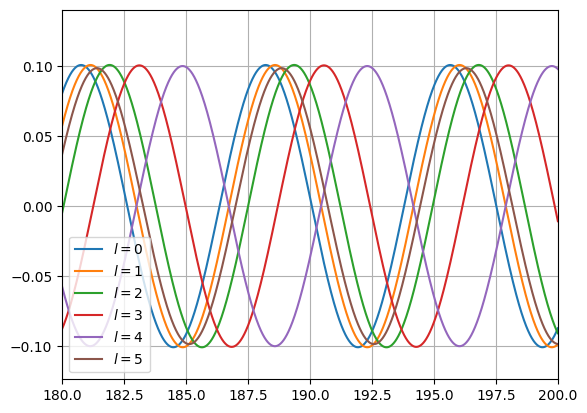

In [85]:
fig, ax = plt.subplots()
ax.set_xlim(180,200)
for j in range(6):
    psi = Numerov_C(E,h,j,r,sigma)
    PSI = normalize(psi,r)
    ax.plot(r, PSI, label=rf'$l={j}$')   
plt.legend(loc='best')
plt.grid()
plt.show()

## Step 2: phase shifts

define Bessel functions using the recursive method introduced in class

In [7]:
# Define Bessel functions

def j_1(r):
    return np.sin(r)/(r**2) - np.cos(r)/r
    
def n_1(r):
    return -np.cos(r)/(r**2) - np.sin(r)/r
    
    
def j_0(r):
    return np.sin(r)/r
    
def n_0(r):
    return -np.cos(r)/r
    
'''
 define the recursion relations
 input: l - order of bessel
        sl - l-th bessel evaluated at r
        sl1 - (l-1)-th bessel evaluated at r
        r - point to evaluate the bessel
 output: l+1 bessel, evaluated at r
'''
def recursive_bessel(l,sl,sl1,r):
    return ((2*l+1)/(r))*sl - sl1

'''   
 define a function to create a matrix of Bessel functions
 input: l - maximum order of bessel, 
        r - array of r values
 output: two matrices of Bessels (one of first kind, one of second kind) of order 0,...,l-1 evaluated on an array r
''' 
def Bessel_l(l,r):
    bess_matj = np.zeros((l,len(r)))
    bess_matn = np.zeros((l,len(r)))

    for j in range(len(r)):
        bess_matj[0][j] = j_0(r[j])
        bess_matn[0][j] = n_0(r[j])
        bess_matj[1][j] = j_1(r[j])
        bess_matn[1][j] = n_1(r[j])
        
    for w in range(2,l):
        for j in range(len(r)):
            bess_matj[w][j] = recursive_bessel(w-1,bess_matj[w-1][j], bess_matj[w-2][j],r[j])
            bess_matn[w][j] = recursive_bessel(w-1,bess_matn[w-1][j], bess_matn[w-2][j],r[j])
            
    return bess_matj, bess_matn
  

Compare the recursion-relation Bessels against Scipy

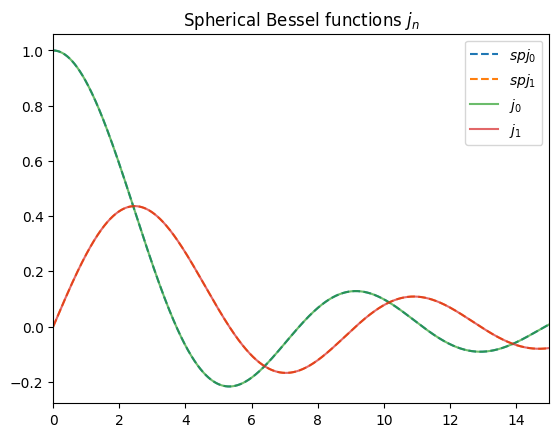

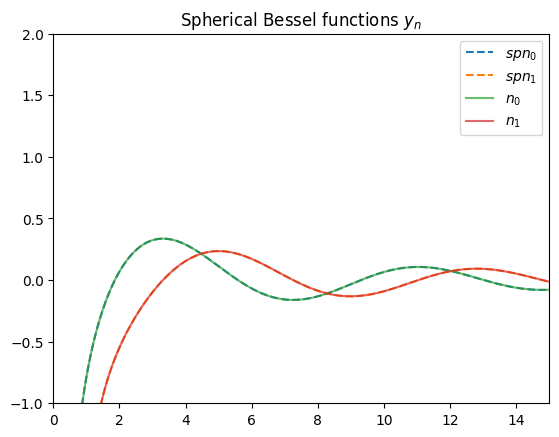

In [8]:
from scipy.special import spherical_jn
from scipy.special import spherical_yn

# bessels from recursion relations
jj, nn = Bessel_l(l,np.sqrt(1/a*E)*r) 


#first plot: spherical bessel functions of the first kind
fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_title(r'Spherical Bessel functions $j_n$')
# scipy bessels are dashed
for n in np.arange(0, 2):
    ax.plot(r, spherical_jn(n, np.sqrt(1/a*E)*r), label=rf'$spj_{n}$', linestyle='dashed')   
# our bessels are solid
for n in np.arange(0, 2):
    ax.plot(r, jj[n][:], label=rf'$j_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()

#second plot: spherical bessels of the second kind
fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_ylim(-1,2)
ax.set_title(r'Spherical Bessel functions $y_n$')
# scipy bessels are dashed
for n in np.arange(0, 2):
    ax.plot(r, spherical_yn(n,np.sqrt(1/a*E)*r), label=rf'$spn_{n}$', linestyle='dashed')   
# our bessels are solid
for n in np.arange(0, 2):
    ax.plot(r, nn[n][:], label=rf'$n_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()



Now onto computing the phase shifts.

First, define a phase-shift function. Notice that we will use the Scipy Bessels here onwards as computation is actually significantly faster (~10x).

In [90]:
#from now on: the bessels from scipy are actually ~10 times faster than ours. we will use those
from scipy.special import spherical_jn, spherical_yn
# scipy is better than me . these functions are significantly faster than the recursion relations
def Bessel_l_scipy(l, r):
    # Compute orders from 0 to l-1
    orders = np.arange(l)

    # Use broadcasting to get a (l, len(r)) matrix
    bess_matj = spherical_jn(orders[:, None], r[None, :])
    bess_matn = spherical_yn(orders[:, None], r[None, :])

    return bess_matj, bess_matn

'''
define phase shift function
input: r1,r2 - two points to evaluate the phase shift
       r - array of r values for numerov
       l - angular momentum
       En - energy
       lmax - maximum order of bessel
       sigma - parameter of the potential
output: phase shift delta_l as defined in class
'''
def Phase_shift(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l_scipy(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov_C(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    delta_l=np.arctan(tan_delta_l)
    return delta_l

# a simpler phase shift function if i only want tan delta l
def Phase_shift_tg(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l_scipy(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov_C(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    return tan_delta_l




verify that the phase shift we find this way is independent of the choice of the two points r1,r2, for several energies and angular momenta

In [91]:
# (this cell takes forever to run)
#Define E and l vectors
energy_step = 0.03
Evec = [round(z,3) for z in np.arange(0.0,3.6,energy_step)]
Evec[0] = Evec[1]/10
lvec=[z for z in range(0,l,1)]
rep=10
lmax=l

SHIFTS = np.zeros((len(lvec),len(Evec),rep))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        for k in range(rep):
            r1 =randint(6000,len(r)-1)
            rr=r[r1]*4/5-20*k*h
            r2 = round(rr/h)
            SHIFTS[i][j][k]=Phase_shift(r1,r2,r,lvec[i],Evec[j],lmax,sigma)

plot the result from the previous cell

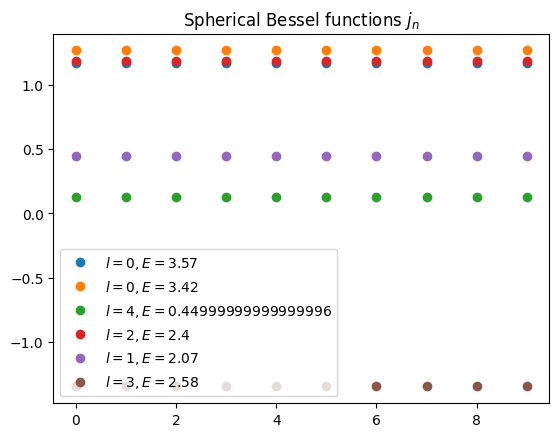

In [92]:
t = [z for z in range(0,rep,1)]

fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(6):
    aa = randint(0,len(Evec)-1)
    bb = randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb][aa][:], 'o',label=rf'$l={bb}, E={aa*energy_step}$')   

plt.legend(loc='best')
plt.show()

Mean and variance of phase shifts

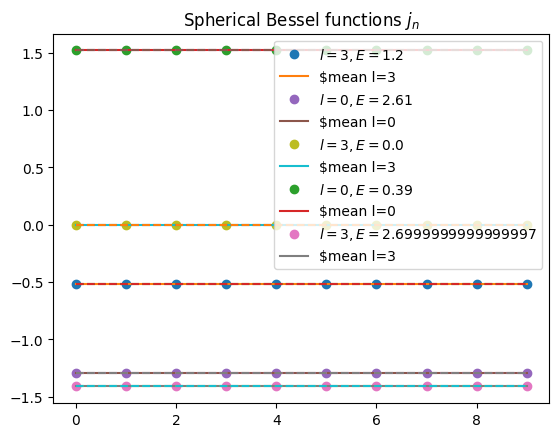

In [93]:
mean_shift=np.zeros((len(lvec),len(Evec)))
var_shift=np.zeros((len(lvec),len(Evec)))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        sum=0
        sumq=0
        for k in range(rep):
            sum+=SHIFTS[i][j][k]
            sumq+=SHIFTS[i][j][k]**2        
        mean_shift[i][j]=sum/rep
        var_shift[i][j]=sumq/rep  - (sum/rep)**2
        

        
fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(5):
    aa = [round(1.2/energy_step),round(2.6/energy_step),round(0.005/energy_step),round(0.4/energy_step),round(2.7/energy_step)]#randint(0,len(Evec)-1)
    bb = [3,0,3,0,3]#randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb[j]][aa[j]][:], 'o',label=rf'$l={bb[j]}, E={aa[j]*energy_step}$')   
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]], label=rf'$mean l={bb[j]}')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]+var_shift[bb[j]][aa[j]], linestyle='dashed')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]-var_shift[bb[j]][aa[j]],  linestyle='dashed')

plt.legend(loc='best')
plt.show()



From this analysis, we can conclude that we can simply take 1 phase shift for each (E,l).

In [97]:
l = 9
#Define E and l vectors
#energy_step = 0.03
#Evec = [round(z,3) for z in np.arange(0.0,3.6,energy_step)]
#Evec[0] = Evec[1]/10
#lvec=[z for z in range(0,l,1)]
Evec = np.logspace(-1,1, num=50)
lvec=[z for z in range(0,l,1)]

rep=1
lmax=l

mean_shift_tg = np.zeros((len(lvec),len(Evec)))

r1 =randint(len(r)-100,len(r)-1)   
r2 =randint(len(r)-300,len(r)-200)   
print(r1,r2)    

for i in range(len(lvec)):
    for j in range(len(Evec)):
            mean_shift_tg[i][j]=Phase_shift_tg(r1,r2,r,lvec[i],Evec[j],lmax,sigma)



19909 19734


## Part 3: Cross section

\begin{equation}
\sigma_{\text{tot}}= \frac{4\pi a}{E} \sum_l (2l+1) \sin^2 \delta_l
\end{equation}
for $a=\hbar^2/2m$

compare what happens when using 6,7,8 as maximum angular momentum quantum number. First, look at partial waves

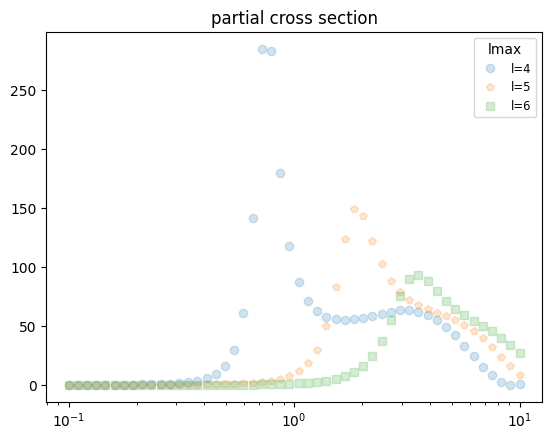

In [98]:
############## compute only partial cross sections
def partialcross(l,shifts):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        tan_l = shifts[l][i]
        sin_squared = tan_l**2/(1+tan_l**2)
        sum+=(2*l+1)*sin_squared
        
        cross[i]=(factor*sum)
    return cross

pcross4 = partialcross(4,mean_shift_tg)
pcross5 = partialcross(5,mean_shift_tg)
pcross6 = partialcross(6,mean_shift_tg)


fig, ax = plt.subplots()
ax.set_title(r'partial cross section')
ax.set_xscale('log')
#ax.set_ylim(0.9e2, 500)
#ax.set_xlim(0.1, 5)
ax.plot(Evec, pcross4, 'o', alpha=.2)  
ax.plot(Evec, pcross5, 'p', alpha=.2)  
ax.plot(Evec, pcross6, 's', alpha=.2)  
#ax.set_ylim(10,500)
plt.legend(['l=4', 'l=5', 'l=6'], loc='best', title='lmax', fontsize='small')
plt.show()

Then, we turn onto the whole cross section for our given value of $\sigma$.

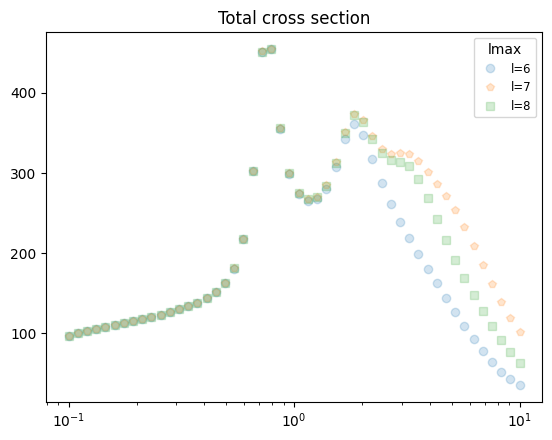

In [100]:
def totalcross(l,shifts):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        for k in range(l):
            tan_l = shifts[k][i]
            sin_squared = tan_l**2/(1+tan_l**2)
            sum+=(2*k+1)*sin_squared
        
        cross[i]=(factor*sum)
   
    return cross

cross6 = totalcross(6,mean_shift_tg)
cross7 = totalcross(7,mean_shift_tg)
cross8 = totalcross(8,mean_shift_tg)

fig, ax = plt.subplots()
ax.set_title(r'Total cross section')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(0.9e2, 500)
#ax.set_xlim(0.1, 5)
ax.plot(Evec, cross6, 'o', alpha=.2)  
ax.plot(Evec, cross8, 'p', alpha=.2)  
ax.plot(Evec, cross7, 's', alpha=.2)  
#ax.set_ylim(10,500)
plt.legend(['l=6', 'l=7', 'l=8'], loc='best', title='lmax', fontsize='small')
plt.show()

We stick to l=8. Comparing the plot with the experimental peaks,

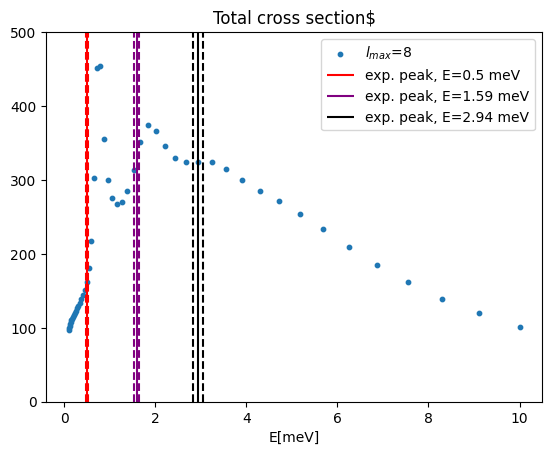

In [103]:
E_exp = [0.50,1.59,2.94] #meV
E_exp_err = [0.02,0.06,0.1] #meV

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
plt.scatter(Evec,cross8,label='$l_{max}$='f'{8}',s=10)
plt.xlabel('E[meV]')


plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.show()

Depending on the value of $\sigma$, scipy.signal.find_peaks might not even find three peaks. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


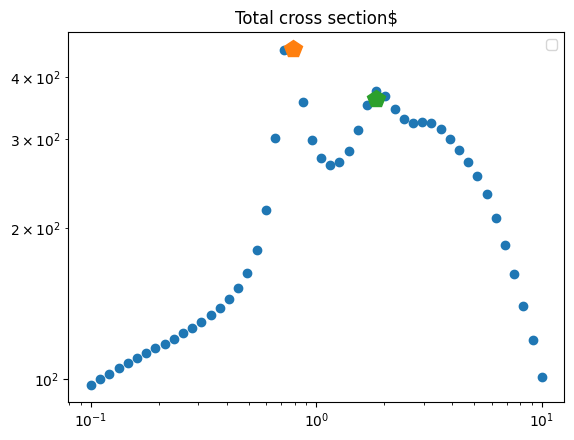

In [105]:
peaks_position6=[]
peak6, peak_position6 = find_peaks(cross6)
peaks_position6.append(list(peak6))

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(Evec,cross8,'o')
for i in range(len(peak6)):
    ax.plot(Evec[peak6[i]], cross6[peak6[i]], 'p', markersize=13)
plt.legend(loc='best')
plt.show()

Thus we skim off the cases where the cross section does not have 3 peaks. We introduce an array of values of $\sigma$ (sigma_test), compute the total cross section as a function of energy (on the usual energy grid Evec) 

In [106]:
sigma_test=np.linspace(3,4,20)

SHIFTS_TEST = np.zeros((len(lvec), len(Evec)))

CROSS=[]

for k in range(len(sigma_test)):
    for i in range(len(lvec)):
        for j in range(len(Evec)):
            
            SHIFTS_TEST[i][j]=Phase_shift(r1,r2,r,lvec[i],Evec[j],lmax,sigma_test[k])
            
    cross_test=totalcross(6,SHIFTS_TEST)
    CROSS.append(cross_test)



peaks_results = []

for i in range(len(sigma_test)):
    y = CROSS[i]
    peak_indices, _ = find_peaks(y)
    
    if len(peak_indices) == 3:
        peak_energies = Evec[peak_indices]
        peak_cross_sections = y[peak_indices]

        result = {
            'sigma': sigma_test[i],
            'energies': peak_energies,
            'cross_sections': peak_cross_sections
        }
        
        peaks_results.append(result)

# --- Stampa dei risultati trovati ---
for res in peaks_results:
    print(f"\nSigma = {res['sigma']:.3f}")
    for e in zip(res['energies']):
        print(f"  Picco a E = {e[0]:.3f} meV") 
        


Sigma = 3.211
  Picco a E = 0.133 meV
  Picco a E = 0.409 meV
  Picco a E = 1.389 meV

Sigma = 3.263
  Picco a E = 0.121 meV
  Picco a E = 0.339 meV
  Picco a E = 1.265 meV

Sigma = 3.316
  Picco a E = 0.256 meV
  Picco a E = 0.409 meV
  Picco a E = 1.151 meV

Sigma = 3.368
  Picco a E = 0.176 meV
  Picco a E = 0.409 meV
  Picco a E = 1.048 meV

Sigma = 3.421
  Picco a E = 0.409 meV
  Picco a E = 0.954 meV
  Picco a E = 1.842 meV

Sigma = 3.526
  Picco a E = 0.720 meV
  Picco a E = 1.842 meV
  Picco a E = 2.683 meV

Sigma = 3.632
  Picco a E = 0.596 meV
  Picco a E = 1.048 meV
  Picco a E = 2.683 meV


Then we fit the experimental peaks against our result, looking to minimise 
\begin{equation}
\Delta^2 (\sigma) = \sum _{i=1}^3 (E_i^{\text{th}}(\sigma)-E_i^\text{exp})^2
\end{equation}

[3.9348842029803572, 4.516561498542341, 4.65446315785547, 5.080699342975651, 1.6193087878849335, 0.17815252378116297, 0.3681839134563514]

Sigma migliore: 3.526
Delta minimo: 0.178153
Energie simulate: [0.71968567 1.84206997 2.6826958 ]
[] 0.3681839134563514


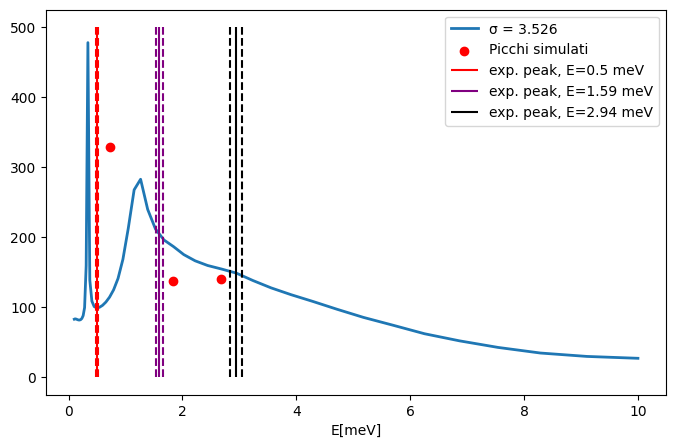

In [108]:
E_peaks_exp = [0.502, 1.589, 2.941] #Position of the experimental peaks in meV

DELTA=[]

for j in range(len(peaks_results)):
    delta=0
    for i in range(len(E_peaks_exp)):
       delta+=(E_peaks_exp[i]-peaks_results[j]['energies'][i] )**2
    DELTA.append(delta) 

print(DELTA)

best_index = np.argmin(DELTA)
best_result = peaks_results[best_index]

print(f"\nSigma migliore: {best_result['sigma']:.3f}")
print(f"Delta minimo: {DELTA[best_index]:.6f}")
print("Energie simulate:", best_result['energies'])



best_sigma = peaks_results[best_index]['sigma']
best_cross_section = CROSS[best_index]  # è un array 1D di stessa lunghezza di Evec

print(peak,delta)
# Plot
ax.set_title(r'Total cross section$')
plt.figure(figsize=(8,5))
plt.plot(Evec, best_cross_section, label=f"σ = {best_sigma:.3f}", linewidth=2)
plt.scatter(peaks_results[best_index]['energies'], peaks_results[best_index]['cross_sections'],
            color='red', zorder=5, label='Picchi simulati')
plt.xlabel('E[meV]')
plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.show()